#### Visualization of Random Sequences in Embedding Space

In [1]:
cd ..

/home/romi/projects/cvc


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os, sys
import collections
import pandas as pd
import matplotlib

SRC_DIR = "cvc"
assert os.path.isdir(SRC_DIR), f"Cannot find src dir: {SRC_DIR}"
sys.path.append(SRC_DIR)
from cvc import model_utils
from lab_notebooks.utils import SC_TRANSFORMER, TRANSFORMER, DEVICE, DATA_DIR
MODEL_DIR = os.path.join(SRC_DIR, "models")
sys.path.append(MODEL_DIR)

FILT_EDIT_DIST = True

PLOT_DIR = os.path.join(os.path.dirname(SRC_DIR), "plots/CDR3_data_plots")
if not os.path.isdir(PLOT_DIR):
    os.makedirs(PLOT_DIR)
PLOT_DIR

'plots/CDR3_data_plots'

#### Prepare Data

In [4]:
data_dir = DATA_DIR + "db_data_appearances.csv"

In [5]:
tcrb_data = pd.read_csv(data_dir, engine="pyarrow")

# drop duplicates
tcrb_data_sample_from = tcrb_data.drop_duplicates()
tcrb_data_sample_from

,,Sequences,Appearances,Private_Public_label
0,0,CASSLGETQYF,1237,1
1,1237,CASSLGYEQYF,1182,1
2,2419,CASSLGGNTEAFF,1181,1
3,3600,CASSLQETQYF,1168,1
4,4768,CASSSSYEQYF,1166,1


#### Analyze Appearances/Abundance

In [7]:
# add column of sequence lengths
tcrb_data_sample_from['Length'] = tcrb_data_sample_from['Sequences'].apply(len)

In [8]:
collections.Counter(tcrb_data_sample_from['Private_Public_label'])

Counter({1: 16046230, 0: 75712467})

In [9]:
# for publicness
tcrb_data_sample_from['publicness_bin'] = pd.cut(tcrb_data_sample_from.Appearances, bins=[0,1,10,25, 50, 100, 150, 200, 250, 300, 350, 400,450, 500,550, 600,650, 700,750, 800,850, 900,950,1000, 2000], labels=['0-1','1-10','10-25', '25-50', '50-100','100-150','150-200', '200-250', '250-300', '300-350','350-400', '400-450', '450-500','500-550','550-600','600-650', '650-700','700-750', '750-800', '800-850','850-900','900-950','950-1000','1000+'])
tcrb_data_sample_from.publicness_bin.value_counts()

0-1         75712467
1-10        14339947
10-25        1092432
25-50         350160
50-100        159639
100-150        47101
150-200        21372
200-250        11588
250-300         7073
300-350         4582
350-400         3283
400-450         2247
450-500         1644
500-550         1235
550-600          990
600-650          720
650-700          577
700-750          411
750-800          341
800-850          275
850-900          221
900-950          145
1000+            129
950-1000         118
Name: publicness_bin, dtype: int64

In [10]:
stats = collections.Counter(tcrb_data_sample_from['Appearances']) # to draw appearance histogram (no bins)
stats

Counter({1237: 1,
         1182: 1,
         1181: 1,
         1168: 1,
         1166: 1,
         1155: 1,
         1147: 1,
         1142: 2,
         1139: 1,
         1137: 2,
         1135: 1,
         1130: 1,
         1129: 1,
         1124: 1,
         1121: 2,
         1120: 1,
         1118: 1,
         1117: 1,
         1113: 1,
         1112: 2,
         1110: 1,
         1107: 1,
         1105: 1,
         1102: 1,
         1100: 1,
         1099: 2,
         1098: 1,
         1097: 1,
         1093: 1,
         1092: 2,
         1091: 2,
         1090: 2,
         1088: 2,
         1087: 1,
         1086: 2,
         1082: 2,
         1078: 1,
         1076: 1,
         1074: 1,
         1073: 1,
         1072: 1,
         1070: 1,
         1067: 1,
         1065: 1,
         1064: 2,
         1063: 1,
         1062: 2,
         1061: 4,
         1059: 2,
         1058: 1,
         1056: 1,
         1055: 1,
         1051: 1,
         1049: 1,
         1048: 2,
         1

In [11]:
# reverse order of stats dictionary
from collections import OrderedDict
reversed_stats = OrderedDict(reversed(list(stats.items())))

#### Subsample Data

In [14]:
# sample 500,000 rows
#tcrb_data_sample = tcrb_data_sample_from.sample(n=500000)

# for db data (for equal distributions between plots)
# We will sample 15% public and 85% private sequences to have a roughly equal distribution to previous samplings.
TOTAL_COUNT = 1000000#100000
PUBLIC_COUNT = int(.15 * TOTAL_COUNT)
PRIVATE_COUNT = int(.85 * TOTAL_COUNT)
public_sample = tcrb_data_sample_from.query('Private_Public_label == 1').sample(PUBLIC_COUNT, random_state=10)
private_sample = tcrb_data_sample_from.query('Private_Public_label == 0').sample(PRIVATE_COUNT, random_state=10)
# join public and private samples
tcrb_data_sample = pd.concat([public_sample, private_sample])

#### Genarate 10000 random sequences

In [17]:
# Generate 10000 random sequences size 11 - 20 with even distribution of amino acids
amino_acids = ['R','H','K','D','E','S','T','N','Q','C','U','G','P','A','V','I','L','M','F','Y','W']
RANDOM_SEQ_NUM = 50000
seq_list = list()
from random import randint
for i in range(RANDOM_SEQ_NUM):
    seq = ""
    length = randint(5,25)
    m = 0
    while m<=length:
        seq += amino_acids[randint(0,len(amino_acids)-1)]
        m+=1
    seq_list.append(seq)
seq_list

# create dataframe from sequence list
data_for_df = {'Sequences': seq_list, 'Private_Public_label': 2, 'Appearances':0}
random_seq_df = pd.DataFrame(data_for_df)

In [32]:
tcrb_data_sample

,,Sequences,Appearances,Private_Public_label,Length,publicness_bin
10504849,98095014.0,CASSVGRGPSPLHF,2,1,14.0,1-10
1805060,63360395.0,CATSDPSGGPTDTQYF,10,1,16.0,1-10
14645880,106377076.0,CASSYRGLAGEEQYF,2,1,15.0,1-10
3048580,73069916.0,CASSSRGTADGYTF,6,1,14.0,1-10
15358041,107801398.0,CAWSVGREHGYTF,2,1,13.0,1-10
...,...,...,...,...,...,...
49995,NaN,EETYEVUKRADAMMWN,0,2,NaN,NaN
49996,NaN,GNFWLWC,0,2,NaN,NaN
49997,NaN,ECSQPLUV,0,2,NaN,NaN
49998,NaN,QPKEPPQGAVAKTWHMICLR,0,2,NaN,NaN


In [18]:
# concat to tcrb_data_sample
# join public and private samples
tcrb_data_sample_concatinated = pd.concat([tcrb_data_sample, random_seq_df])
tcrb_data_sample = tcrb_data_sample_concatinated
tcrb_data_sample

,,Sequences,Appearances,Private_Public_label,Length,publicness_bin
10504849,98095014.0,CASSVGRGPSPLHF,2,1,14.0,1-10
1805060,63360395.0,CATSDPSGGPTDTQYF,10,1,16.0,1-10
14645880,106377076.0,CASSYRGLAGEEQYF,2,1,15.0,1-10
3048580,73069916.0,CASSSRGTADGYTF,6,1,14.0,1-10
15358041,107801398.0,CAWSVGREHGYTF,2,1,13.0,1-10
...,...,...,...,...,...,...
49995,NaN,EETYEVUKRADAMMWN,0,2,NaN,NaN
49996,NaN,GNFWLWC,0,2,NaN,NaN
49997,NaN,ECSQPLUV,0,2,NaN,NaN
49998,NaN,QPKEPPQGAVAKTWHMICLR,0,2,NaN,NaN


#### Create and Display embeddings

In [19]:
from cvc.embbeding_wrapper import EmbeddingWrapper
# Create embeddings
embed_wrap = EmbeddingWrapper(
    TRANSFORMER, DEVICE, tcrb_data_sample, batch_size=1024, method="mean", layers=[-1], pbar=True)
embed_wrap.embeddings.shape

(1050000, 768)

In [20]:
# create anndata object
tcrb_embeddings_adata = embed_wrap.create_anndata()

/opt/conda/envs/tcrbert/lib/python3.9/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [25]:
# adata without random sequences
tcrb_embeddings_adata_pubpriv = tcrb_embeddings_adata[tcrb_embeddings_adata.obs['Private_Public_label'].isin([0,1])]
tcrb_embeddings_adata_pubpriv

View of AnnData object with n_obs × n_vars = 1000000 × 768
    obs: '', 'Sequences', 'Appearances', 'Private_Public_label', 'Length', 'publicness_bin'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [41]:
seqs_shuffled = tcrb_embeddings_adata_pubpriv.obs.Sequences
# select 50k sequences randomly
seqs_shuffled = seqs_shuffled.sample(50000)
# for each of the sequences, shuffle the amino acids
seqs_shuffled = seqs_shuffled.apply(lambda x: ''.join(random.sample(x, len(x))))
seqs_shuffled = seqs_shuffled.tolist()
seqs_shuffled_df = pd.DataFrame(seqs_shuffled, columns=['Sequences'])

In [42]:
from cvc.embbeding_wrapper import EmbeddingWrapper
# Create embeddings
embed_wrap_shuffled = EmbeddingWrapper(
    TRANSFORMER, DEVICE, seqs_shuffled_df, batch_size=1024, method="mean", layers=[-1], pbar=True)
embed_wrap_shuffled.embeddings.shape

(50000, 768)

In [43]:
embed_wrap_shuffled.sequences_df.loc[:, 'Private_Public_label'] = 2

In [48]:
import anndata as ad
tcrb_embeddings_adata_w_shuffled = ad.concat([tcrb_embeddings_adata_pubpriv, embed_wrap_shuffled.create_anndata()], axis=0)

/opt/conda/envs/tcrbert/lib/python3.9/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [49]:
tcrb_embeddings_adata_w_shuffled

AnnData object with n_obs × n_vars = 1050000 × 768
    obs: 'Sequences', 'Private_Public_label'
    obsm: 'X_pca', 'X_umap'

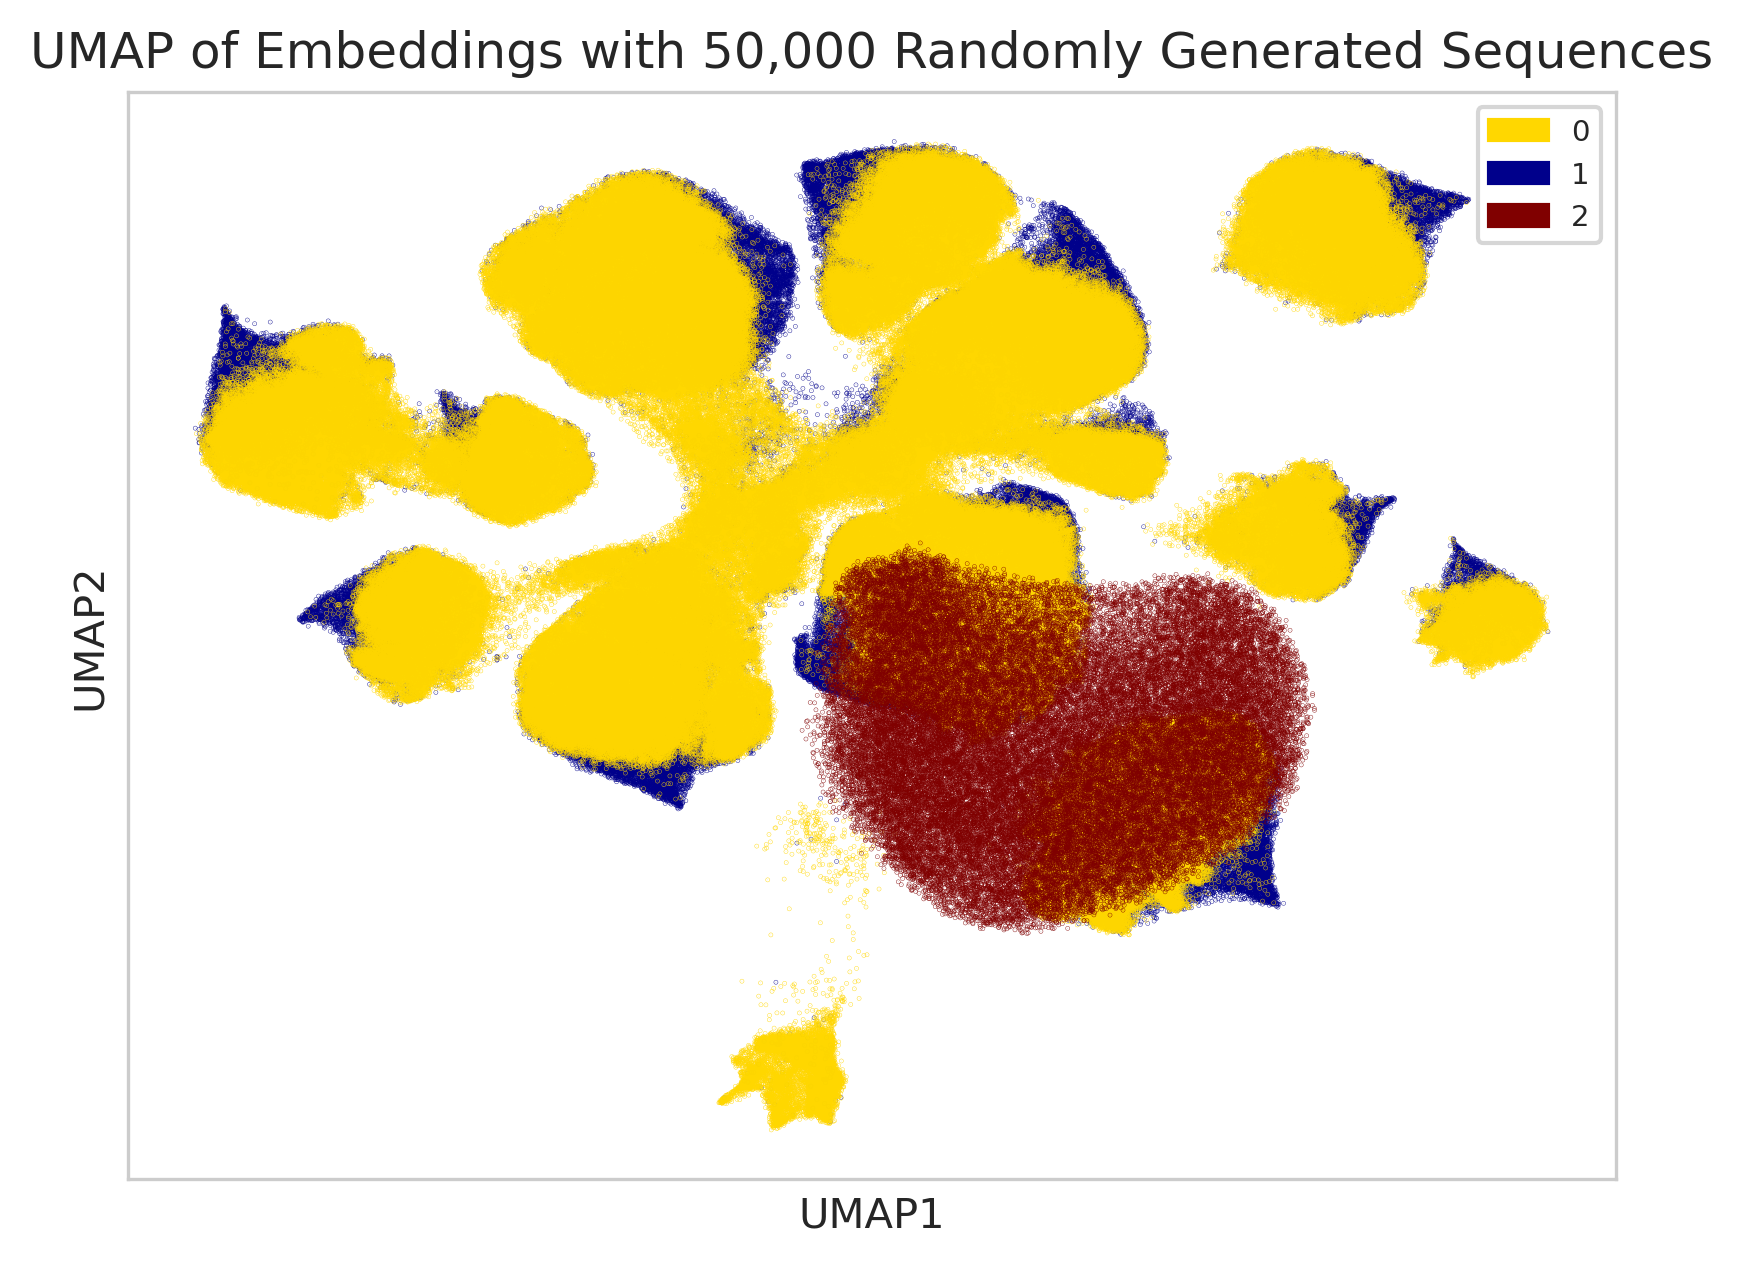

In [50]:
# Plot embeddings
colors=['gold', 'darkblue','maroon']
fig = embed_wrap.plot_embedding(
    # anndata=tcrb_embeddings_adata_pubpriv,
    anndata=tcrb_embeddings_adata_w_shuffled,
    color_embed='Private_Public_label',
    color_map=matplotlib.colors.ListedColormap(colors),
    title="UMAP of Embeddings with 50,000 Randomly Generated Sequences",
    # title="UMAP of Embeddings, Colored by Public/Private Label",
    legend_size=7,
    plot_pdf_path=os.path.join(PLOT_DIR, "cr_model_db_data_umap_50k_rand.pdf")
)

#### Analyze public distance of specific sequences from UMAP

In [16]:
coords = tcrb_embeddings_adata.obsm['X_umap']
sequence_df = tcrb_embeddings_adata.obs.reset_index(drop=True)
seqs = sequence_df['Sequences']
is_public = sequence_df['Private_Public_label'] == 1

In [22]:
# Select random row that is public
public_row = sequence_df[is_public].sample(1)
public_row_idx = public_row.index[0]
# get its x, y coordinates
public_x, public_y = coords[public_row_idx]

# Select top 10 closest coordinages indices to public x, y
import numpy as np
closest = np.argsort(np.linalg.norm(coords - [public_x, public_y], axis=1))[1:10]

# 10 random sequences
# len_coords = len(coords)
# closest = np.random.choice(len_coords, 10, replace=False)

# farthest
# closest = np.argsort(np.linalg.norm(coords - [public_x, public_y], axis=1))[-10:]

# get the sequences of the closest
sequences_of_closest = seqs[closest]

sequences_of_closest = sequences_of_closest.tolist()
chosen_seq = public_row['Sequences'].values[0]

print("chosen:", chosen_seq)
print("closest:", sequences_of_closest)

chosen: CSARDSRGSTNEKLFF
closest: ['CAWSVAGTAEKLFF', 'CASRFPGQGAGEKLFF', 'CASRQTGTKNEKLFF', 'CASSRGAMNEKLFF', 'CASSQPGQSFEKLFF', 'CASSGHPGNEKLFF', 'CASSIGHGTGGEKLFF', 'CASSAHWANEKLFF', 'CASRLGTDSEKLFF']


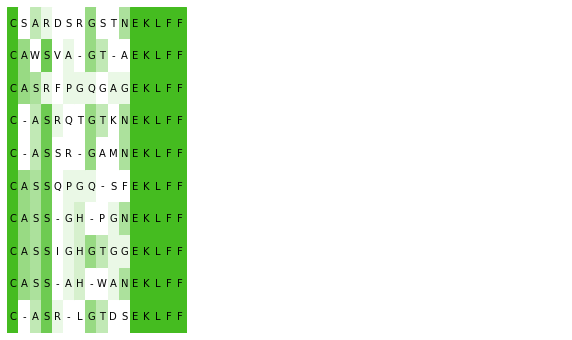

In [23]:
import matplotlib.pyplot as plt
# plot alignment between all sequences
from biotite.sequence import align

sequences = [chosen_seq] + sequences_of_closest

import biotite.sequence as seq
seq_list = [seq.ProteinSequence(seq_str) for seq_str in sequences]
alignment, order, _, _ = align.align_multiple(seq_list, matrix=align.SubstitutionMatrix.std_protein_matrix())

import biotite.sequence.graphics as graphics
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
symbol_plotter = graphics.LetterSimilarityPlotter(ax)
graphics.plot_alignment(ax, alignment, symbol_plotter)
# show figure
fig.show()